In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as de
import dedalus.extras.plot_tools as plot_tools
import atmospheres as atmos
import tides
import parameters as param
import mpi4py.MPI as MPI
import uuid
import logging
logger = logging.getLogger(__name__)
%matplotlib notebook

In [10]:
import importlib
importlib.reload(param)
param.μ = 1e-20

## Problem

In [11]:
kx = param.k_tide
domain, problem = tides.eigenmodes_1d(param, kx=kx)

2018-11-06 00:41:35,858 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 9.5e+01/s
2018-11-06 00:41:36,332 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 7.4e+01/s
2018-11-06 00:41:36,338 atmospheres 0/1 INFO :: Perturbation norm: 2.969452692755053e-07
2018-11-06 00:41:36,648 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.1e+02/s
2018-11-06 00:41:36,653 atmospheres 0/1 INFO :: Perturbation norm: 1.7301898559618714e-14
2018-11-06 00:41:36,657 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10


## Solver

In [12]:
# Build solver
from dedalus.tools.sparse import scipy_sparse_eigs
solver = problem.build_solver()
pencil = solver.pencils[0]

N = 10
target = 0.1
#solver.solve(pencil)
solver.solve_sparse(pencil, N=N, target=-1j*target)
solver.adjoint_eigenvalues, solver.adjoint_eigenvectors = scipy_sparse_eigs(A=pencil.L_exp.getH(), B=-pencil.M_exp.getH(), N=N, target=np.conj(-1j*target))

In [17]:
sorting = np.argsort(np.abs(solver.eigenvalues))
solver.eigenvalues = solver.eigenvalues[sorting]
solver.eigenvectors = solver.eigenvectors[:,sorting]

sorting = np.argsort(np.abs(solver.adjoint_eigenvalues.conj()))
solver.adjoint_eigenvalues = solver.adjoint_eigenvalues[sorting]
solver.adjoint_eigenvectors = solver.adjoint_eigenvectors[:,sorting]

print(solver.eigenvalues)
print('Adjoint evals match:', np.allclose(solver.eigenvalues, solver.adjoint_eigenvalues.conj()))

[ 2.17554881e-13-0.01432785j  6.54449789e-14-0.01593085j
 -1.84842675e-14-0.0179355j  -1.79246675e-14-0.02051337j
 -3.62124551e-14-0.0239492j   1.38247860e-14-0.02875173j
  1.69928381e-15-0.03592481j  2.01902329e-15-0.04774907j
  2.00833216e-16-0.0706632j  -9.75729680e-16-0.13131884j]
Adjoint evals match: True


<IPython.core.display.Javascript object>


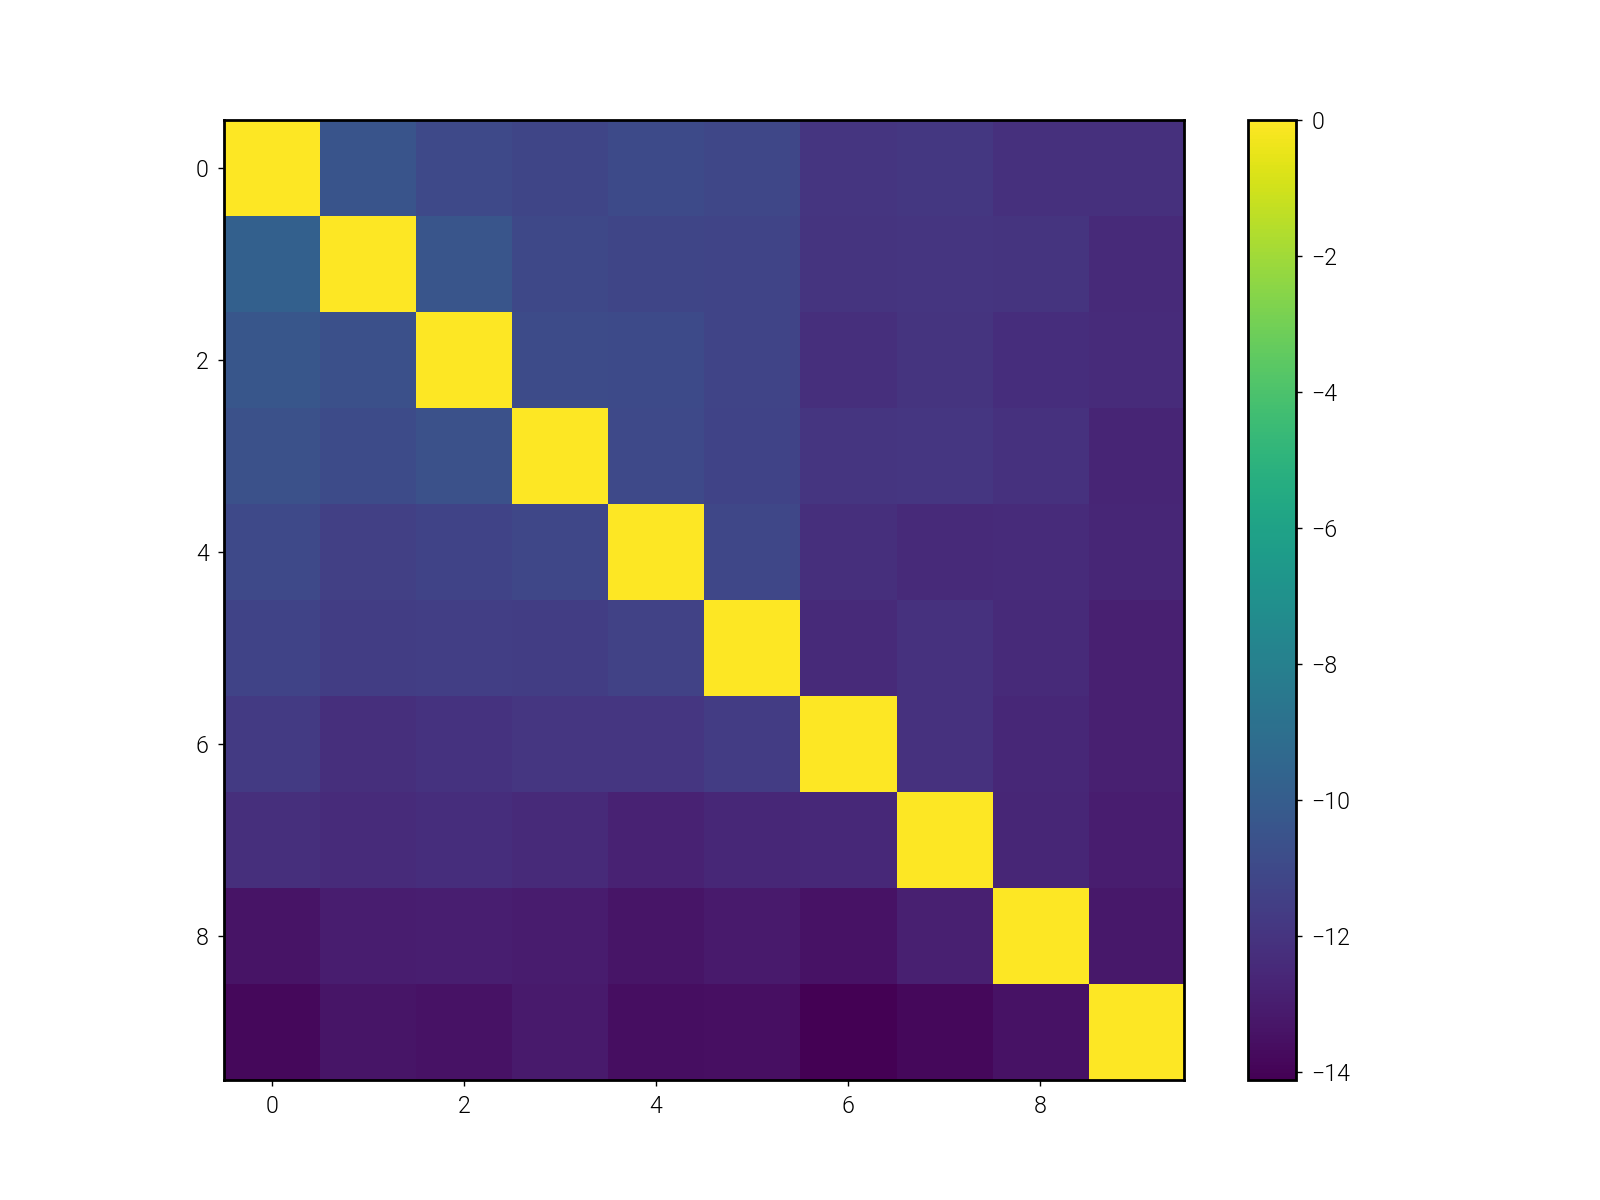

[1.-1.78006520e-16j 1.+7.42522350e-17j 1.+9.84286994e-17j
 1.+4.50718930e-17j 1.-1.30459920e-17j 1.-1.58926568e-16j
 1.-3.29782361e-16j 1.+1.10486859e-16j 1.-1.75969073e-16j
 1.-3.42045675e-16j]


In [25]:
# Normalize raw eigenvectors
norm = solver.eigenvectors.T.conj() @ solver.eigenvectors
eigenvectors = solver.eigenvectors / np.sqrt(np.diag(norm))
norm = solver.adjoint_eigenvectors.T.conj() @ solver.adjoint_eigenvectors
adjoint_eigenvectors = solver.adjoint_eigenvectors / np.sqrt(np.diag(norm))
# Normalize adjoint modes
g = adjoint_eigenvectors.T.conj() @ pencil.M @ eigenvectors
evecs_adj_norm = adjoint_eigenvectors / np.diag(g).conj()
evecs_norm = eigenvectors 
g = evecs_adj_norm.T.conj() @ pencil.M @ evecs_norm
proj = evecs_adj_norm.T.conj() @ pencil.M

plt.figure()
plt.imshow(np.log10(np.abs(g)), cmap='viridis')
plt.colorbar()
print(np.diag(g))

<IPython.core.display.Javascript object>


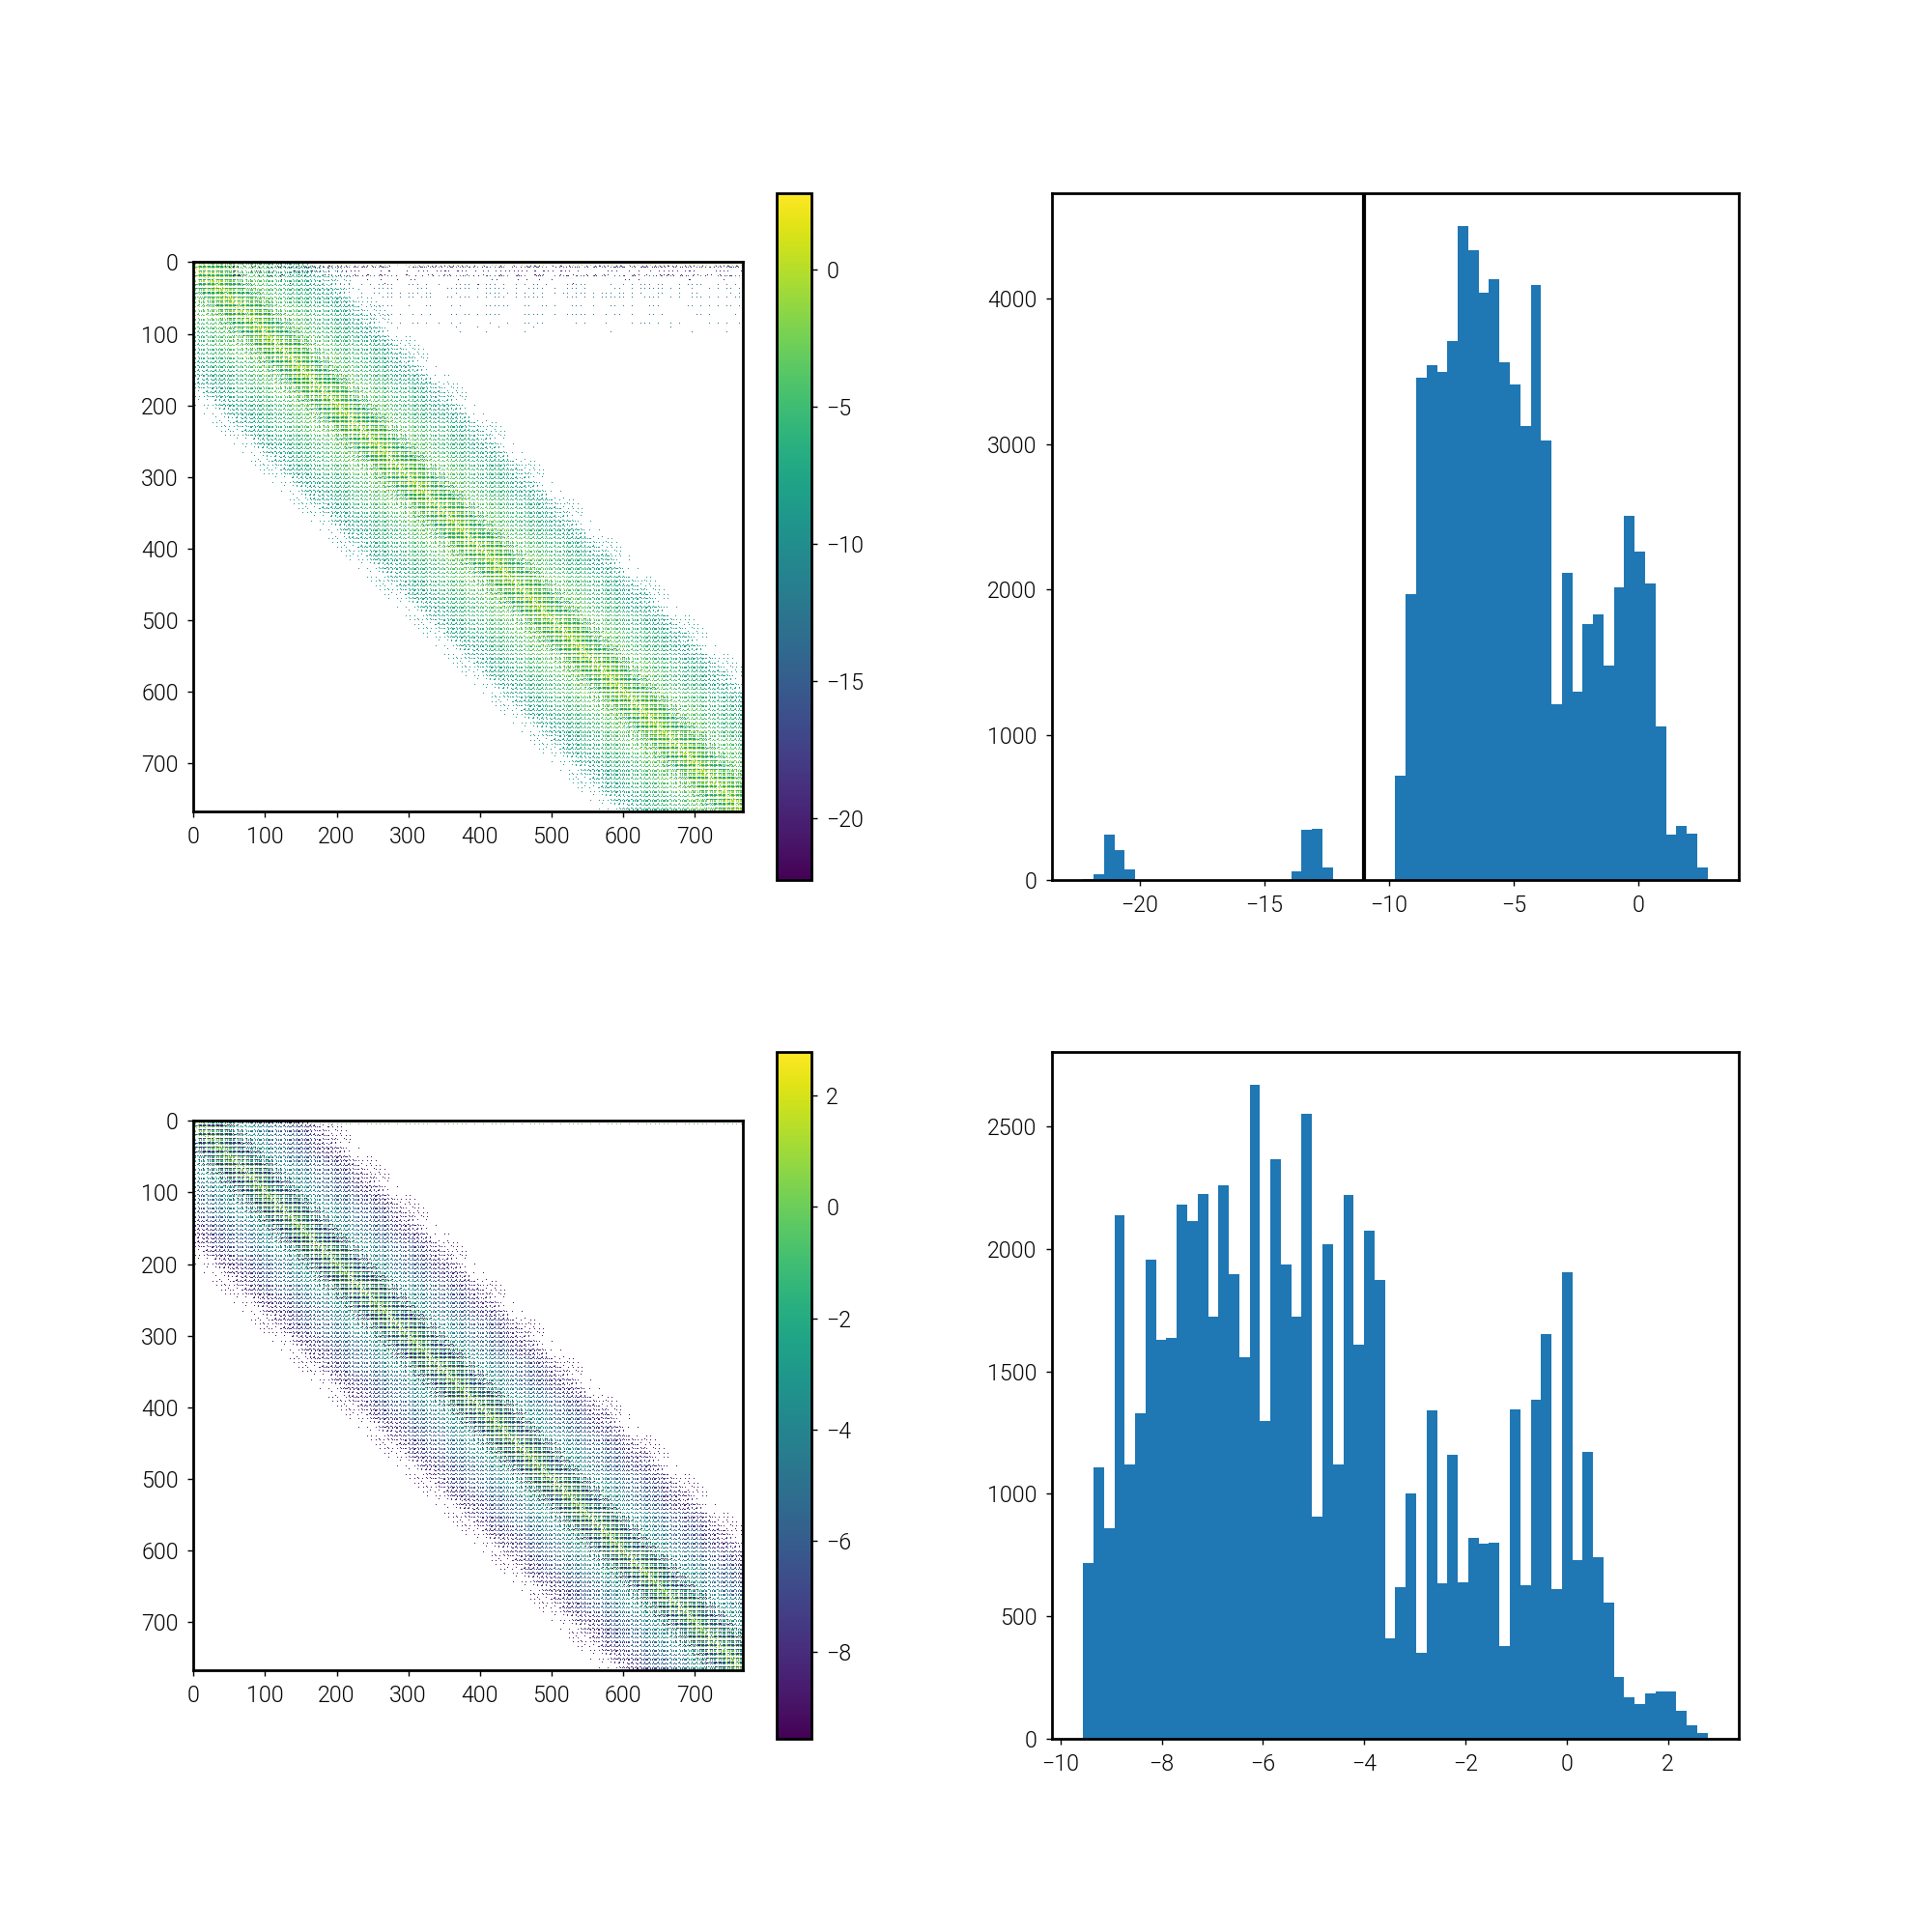

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  


In [19]:
pencil = solver.pencils[0]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))
# Plot full L matrix
L = LF = pencil.L_full.copy()
M = pencil.M_full.copy()
im1 = ax1.imshow(np.log10(np.abs(L.A)), cmap='viridis')
im2 = ax2.hist(np.log10(np.abs(L.A[L.A!=0])), bins=60)
ax2.axvline(np.log10(param.matrix_cutoff), c='k')
ax1.set_aspect('equal')
plt.colorbar(im1, ax=ax1)
# Plot truncated L matrix
L = pencil.L.copy()
M = pencil.M.copy()
im1 = ax3.imshow(np.log10(np.abs(L.A)), cmap='viridis')
im2 = ax4.hist(np.log10(np.abs(L.A[L.A!=0])), bins=60)
plt.colorbar(im1, ax=ax3)

<IPython.core.display.Javascript object>


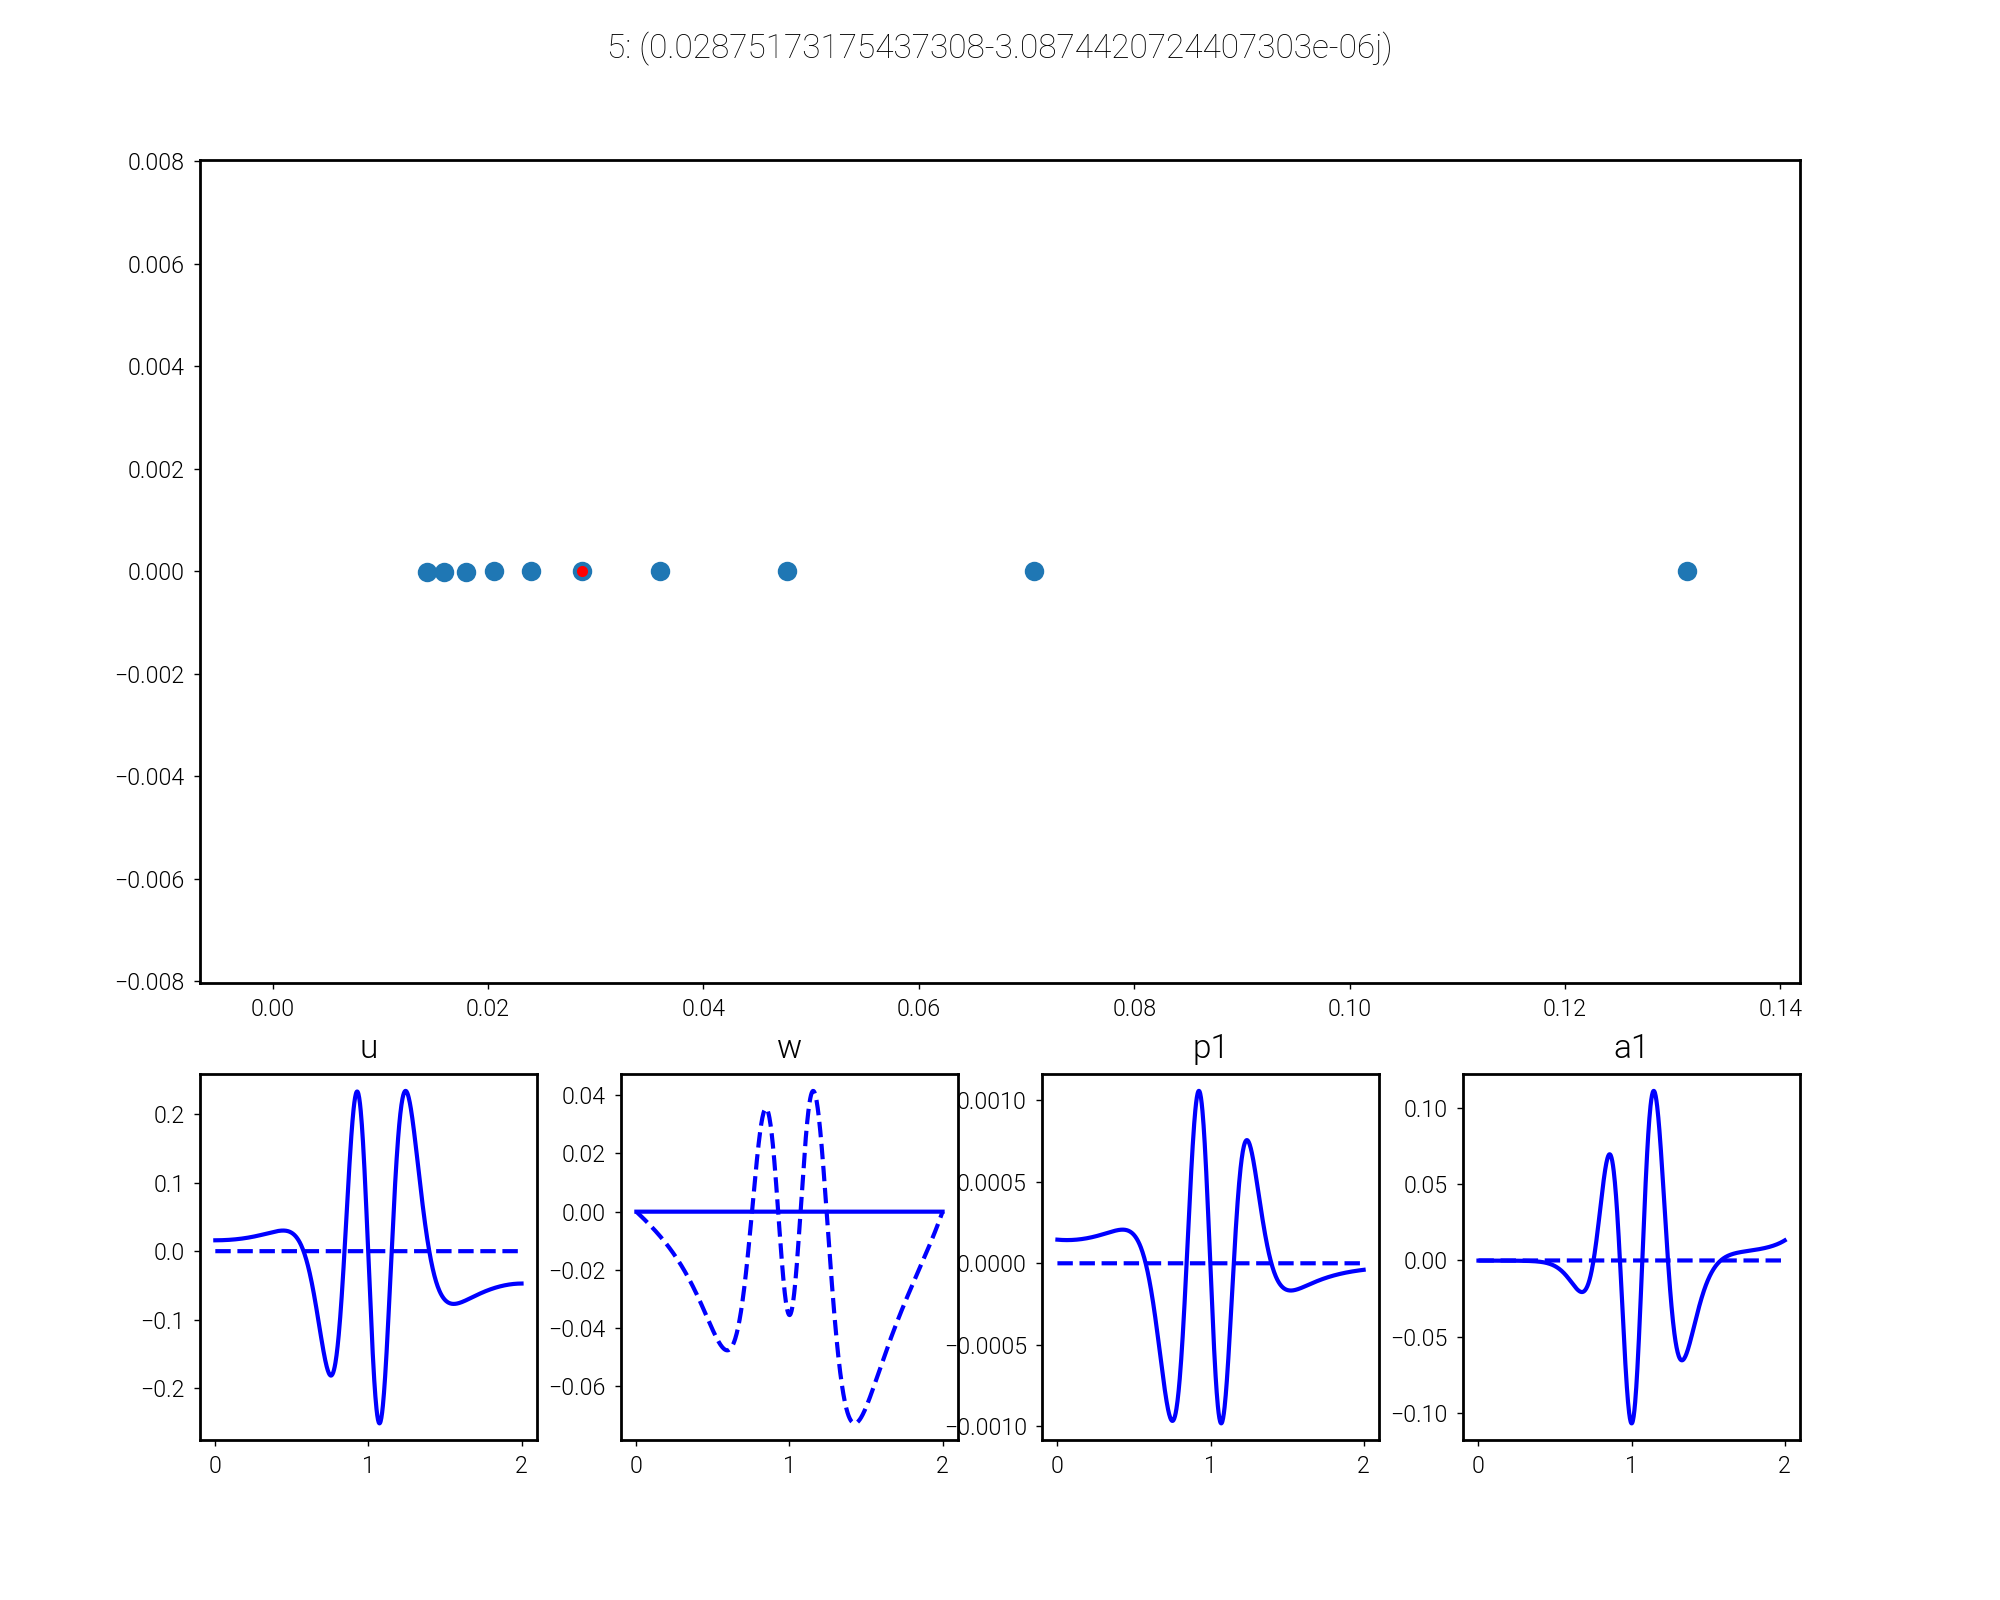

6

In [7]:
# Filter eigenvalues
evals = solver.eigenvalues.copy()
freqs = 1j * evals

fig = plt.figure(figsize=(10,8))
ax1 = plt.subplot2grid((3,4), (0,0), rowspan=2, colspan=4)
ax1.scatter(freqs.real, freqs.imag, picker=2)
active_dot, = ax1.plot(0, 0, '.r')
active_ev = fig.suptitle('')

ax2 = plt.subplot2grid((3,4), (2,0))
ax3 = plt.subplot2grid((3,4), (2,1))
ax4 = plt.subplot2grid((3,4), (2,2))
ax5 = plt.subplot2grid((3,4), (2,3))

p0 = problem.namespace['p0']
a0 = problem.namespace['a0']
scales = 10
p0.set_scales(scales)
a0.set_scales(scales)
for field in solver.state.fields:
    field.set_scales(scales)
z = domain.grid(0, scales=scales)

def plot_mode(event):
    # Update active eigenvalue

    x, y = event.mouseevent.xdata, event.mouseevent.ydata
    index = np.argmin(np.abs(freqs - (x + 1j*y)))
    ev = freqs[index]
    active_dot.set_xdata([ev.real])
    active_dot.set_ydata([ev.imag])
    active_ev.set_text('%i: %s' %(index, ev))
    # Plot mode
    solver.set_state(index)
    u = solver.state['u']
    w = solver.state['w']
    p1 = solver.state['p1']
    a1 = solver.state['a1']
    ρ1 = -a1['g'] / a0['g']**2
    phase = p1['g'][0]
    phase = phase / np.abs(phase)
    ax2.cla()
    ax2.plot(z, (u['g']/phase).real, '-b')
    ax2.plot(z, (u['g']/phase).imag, '--b')
    ax2.set_title('u')
    ax3.cla()
    ax3.plot(z, (w['g']/phase).real, '-b')
    ax3.plot(z, (w['g']/phase).imag, '--b')
    ax3.set_title('w')
    ax4.cla()
    ax4.plot(z, (p1['g']/phase).real, '-b')
    ax4.plot(z, (p1['g']/phase).imag, '--b')
    ax4.set_title('p1')
    ax5.cla()
    ax5.plot(z, (a1['g']/phase).real, '-b')
    ax5.plot(z, (a1['g']/phase).imag, '--b')
    ax5.set_title('a1')

fig.canvas.mpl_connect('pick_event', plot_mode)

In [23]:
# Solve dense to plot normalized modes
import modes
evals, evecs, adj_evals, adj_evecs, proj, sevp, pevp = modes.compute_eigenmodes(param, param.k_tide, sparse=False)
solver = sevp
problem = solver.problem
domain = solver.domain

2018-11-05 13:21:15,943 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.6e+01/s
2018-11-05 13:21:16,399 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 7.0e+01/s
2018-11-05 13:21:16,405 atmospheres 0/1 INFO :: Perturbation norm: 2.969452692755053e-07
2018-11-05 13:21:16,703 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.0e+02/s
2018-11-05 13:21:16,708 atmospheres 0/1 INFO :: Perturbation norm: 1.7301898559618714e-14
2018-11-05 13:21:16,712 problems 0/1 INFO :: Solving EVP with homogeneity tolerance of 1.000e-10
2018-11-05 13:21:44,208 modes 0/1 INFO :: Max eval mismatch: 0.000000e+00


/Users/kburns/Hg/pg_coupling/compressible/notebooks/modes.py:35: ComplexWarning: Casting complex values to real discards the imaginary part
  energies[i] = E_op.evaluate()['c'][0]


<IPython.core.display.Javascript object>


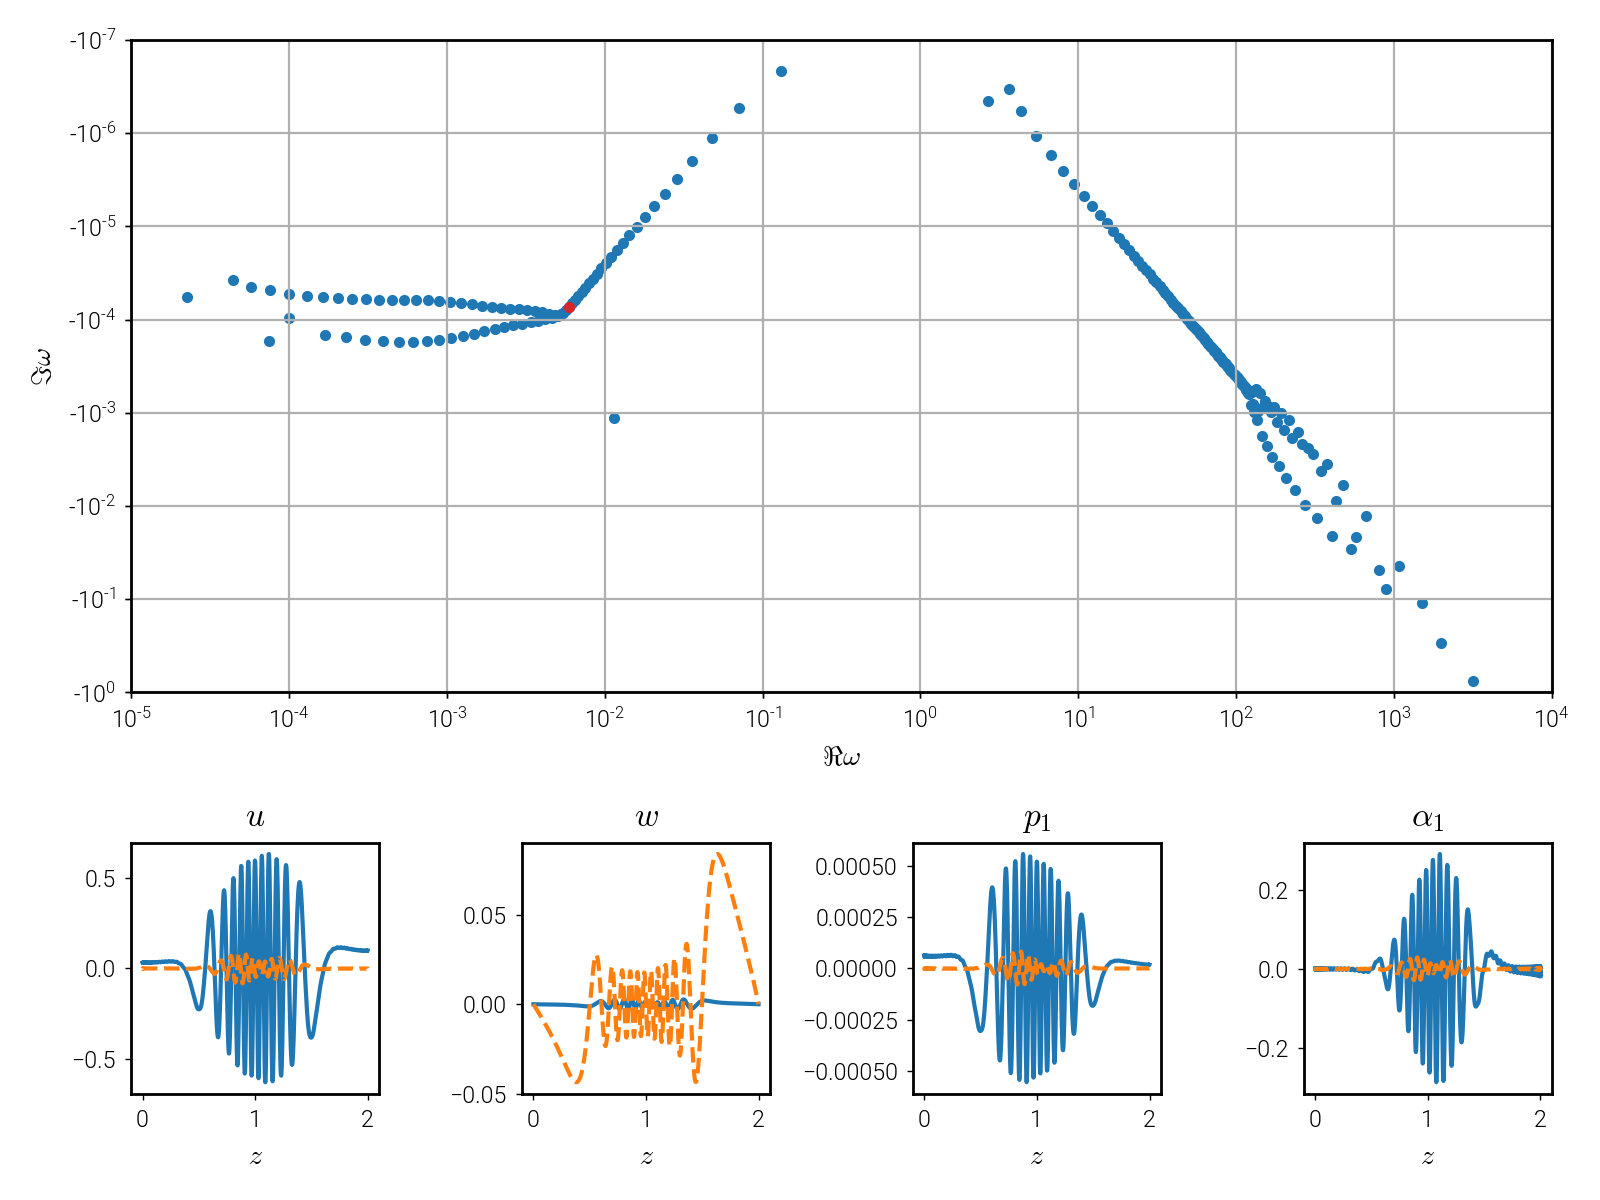

6

In [22]:
# Filter eigenvalues
evals = solver.eigenvalues.copy()
freqs = 1j * evals

fig = plt.figure(figsize=(8,6))
ax1 = plt.subplot2grid((3,4), (0,0), rowspan=2, colspan=4)
ax1.scatter(freqs.real, freqs.imag, marker='.', picker=2)
active_dot, = ax1.plot(0, 0, '.')
active_dot, = ax1.plot(0, 0, '.')
active_dot, = ax1.plot(0, 0, '.')
active_dot, = ax1.plot(0, 0, '.')
ax1.set_xlabel(r'$\Re \omega$')
ax1.set_ylabel(r'$\Im \omega$')
active_ev = fig.suptitle('')

plt.xscale('symlog', linthreshx=1e-10)
plt.yscale('symlog', linthreshy=1e-10)
plt.grid()
plt.xlim([1e-5, 1e4])
plt.ylim([-1e0, -1e-7])

ax2 = plt.subplot2grid((3,4), (2,0))
ax3 = plt.subplot2grid((3,4), (2,1))
ax4 = plt.subplot2grid((3,4), (2,2))
ax5 = plt.subplot2grid((3,4), (2,3))

p0 = problem.namespace['p0']
a0 = problem.namespace['a0']
scales = 10
p0.set_scales(scales)
a0.set_scales(scales)
for field in solver.state.fields:
    field.set_scales(scales)
z = domain.grid(0, scales=scales)

def plot_mode(event):
    # Update active eigenvalue
    x, y = event.mouseevent.xdata, event.mouseevent.ydata
    index = np.argmin(np.abs(freqs - (x + 1j*y)))
    ev = freqs[index]
    active_dot.set_xdata([ev.real])
    active_dot.set_ydata([ev.imag])
    #active_ev.set_text(r'$\omega = %.3e$' %ev)
    # Plot mode
    solver.set_state(index)
    u = solver.state['u']
    w = solver.state['w']
    p1 = solver.state['p1']
    a1 = solver.state['a1']
    ρ1 = -a1['g'] / a0['g']**2
    phase = p1['g'][0]
    phase = phase / np.abs(phase)
    ax2.cla()
    ax2.plot(z, (u['g']/phase).real, '-')
    ax2.plot(z, (u['g']/phase).imag, '--')
    ax2.set_xlabel(r'$z$')
    ax2.set_title(r'$u$')
    ax3.cla()
    ax3.plot(z, (w['g']/phase).real, '-')
    ax3.plot(z, (w['g']/phase).imag, '--')
    ax3.set_xlabel(r'$z$')
    ax3.set_title(r'$w$')
    ax4.cla()
    ax4.plot(z, (p1['g']/phase).real, '-')
    ax4.plot(z, (p1['g']/phase).imag, '--')
    ax4.set_xlabel(r'$z$')
    ax4.set_title(r'$p_1$')
    ax5.cla()
    ax5.plot(z, (a1['g']/phase).real, '-')
    ax5.plot(z, (a1['g']/phase).imag, '--')
    ax5.set_xlabel(r'$z$')
    ax5.set_title(r'$\alpha_1$')
    fig.tight_layout()
    
fig.canvas.mpl_connect('pick_event', plot_mode)

In [29]:
plt.savefig('eigenmodes.pdf')

In [ ]:
eval_neg = solver.eigenvalues.copy()
evec_neg = solver.eigenvectors.copy()

In [ ]:
eval_pos = solver.eigenvalues.copy()
evec_pos = solver.eigenvectors.copy()

In [ ]:
evec_pos.shape

In [ ]:
evec_neg.T.conj() @ evec_pos

In [ ]:
# Print mode info
index = 0
ev = solver.eigenvalues[index]
print('ω_tide:', ev.real)
print('t_tide:', 1 / (ev.real))
print('P_tide:', 2*np.pi / (ev.real))
print('t_visc:', -1 / ev.imag)

In [ ]:
# Plot mode
index = 0
field = 'w'

x = np.linspace(0, param.Lx, 10*param.Nx)[:,None]
z = domain.grid(0, scales=scales)
Z, X = plot_tools.quad_mesh(z.flatten(), x.flatten())

f = solver.state[field]
f.set_scales(scales)
F = f['g'] * np.exp(1j*kx*x)
fig, axes = plt.subplots(1, 1)
axes.pcolormesh(X, Z, F.real)
axes.set_xlabel('x')
axes.set_ylabel('z')
axes.set_title(field)

In [ ]:
# dt(a1) + w*a0z -   a0*div_u = 0
# dt(p1) + w*p0z + γ*p0*div_u = 0

kx = param.k_tide
dz = problem.namespace['dz']
a0z = problem.namespace['a0z']
p0z = problem.namespace['p0z']
γ = param.γ

σ = solver.eigenvalues[index]
u = solver.state['u']
w = solver.state['w']
a1 = solver.state['a1']
p1 = solver.state['p1']

dx = lambda A: 1j*kx*A
dt = lambda A: -1j*σ*A

xix = u / dt(1)
xiz = w / dt(1)
div_u = (dx(u) + dz(w))

a1g = ((-w*a0z + a0*div_u) / dt(1)).evaluate()
p1g = ((-w*p0z - γ*p0*div_u) / dt(1)).evaluate()

In [ ]:
print(np.allclose(a1['c'], a1g['c']))
print(np.allclose(p1['c'], p1g['c']))

In [ ]:
# Test orthogonality
n = 10
g = np.zeros((n, n), dtype=np.float64)
integ = problem.namespace['integ']
weight = 1 / a0
u1 = domain.new_field()
u2 = domain.new_field()
w1 = domain.new_field()
w2 = domain.new_field()
inner_product = integ(weight * (u1*np.conj(u2) + w1*np.conj(w2)))
for i in range(n):
    solver.set_state(i)
    u1['c'] = solver.state['u']['c']
    w1['c'] = solver.state['w']['c']
    for j in range(n):
        solver.set_state(j)
        u2['c'] = solver.state['u']['c']
        w2['c'] = solver.state['w']['c']
        g[i,j] = np.abs(inner_product.evaluate()['c'][0])
g.real

In [ ]:
ev = solver.eigenvalues[index]
γ = ev.imag
ω0 = np.sqrt(ev.real**2 + γ**2)

In [ ]:
ω = 0.05
FA2 = (ω0**2 - ω**2)**2 + 4*γ**2*ω**2
A = FA2**(-1/2)
A

In [ ]:
ω

In [ ]:
2*np.pi / ω

In [ ]:
1 / γ

In [ ]:
# Filter eigenvalues
evals = solver.eigenvalues.copy()
evals = evals[np.isfinite(evals)]
evals = evals[np.abs(evals.real) < 1]
evals = evals[np.abs(evals.imag) > 1e-2]
evals = evals[np.abs(evals.imag) < 1e2]

fig, axes = plt.subplots(1, 1)
axes.scatter(evals.real, evals.imag)

In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)
scales = 4
a0.set_scales(scales)
for field in solver.state.fields:
    field.set_scales(scales)
z = domain.grid(0, scales=scales)
for ev in evals:
    print(ev)
    index = np.where(solver.eigenvalues == ev)[0][0]
    solver.set_state(index)
    u = solver.state['u']['g']
    w = solver.state['w']['g']
    wz = solver.state['wz']['g']
    p1 = solver.state['p1']['g']
    a1 = solver.state['a1']['g']
    ρ1 = -a1 / a0['g']**2
    ax1.plot(z, np.abs(u))
    ax1.set_title('|u|')
    ax2.plot(z, np.abs(w))
    ax2.set_title('|w|')
    ax3.plot(z, np.abs(p1))
    ax3.set_title('|p1|')
    ax4.plot(z, np.abs(ρ1))
    ax4.set_title('|ρ1|')